<a id="head"></a>
### Naive Bayes Salary Classifier
### Oyundari Batbayar

****
The dataset is from [Kaggle](https://www.kaggle.com/competitions/job-salary-prediction/overview), for a competition by Adzuna.

This project's objective is to explore the dataset and deploy a model with Naive Bayes Classifier to predict above or below salary (based on threshold) using job description. 


In [1]:
#!pip install nltk
# here are some code I want to modify on this file

In [2]:
#!pip install wordcloud

In [3]:
#!pip install gensim

In [4]:
#pip install jupyterthemes

In [5]:
# Import libraries/packages
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [6]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  

In [7]:
# load the data (downlaoded from kaggle)
df = pd.read_csv(r"C:\Users\oyund\Downloads\Train_rev1.csv")

In [8]:
# Sample 2500 observations randomly
df = df.sample(2500, random_state = 42)

In [9]:
# Assigning Above and Below based on whether Salary Normalized is above or below 75th Percentile
df['Percentile'] = df['SalaryNormalized'].rank(pct = True)
df.loc[df['Percentile'] > 0.75, 'Target'] = 'Above'
df.loc[df['Percentile'] < 0.75, 'Target'] = 'Below'
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Percentile,Target
30390,68062598,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,NaN,permanent,BMS Sales Specialists,Sales Jobs,"22000 - 25000 per annum + Car,Mobile,Pension,L...",23500,totaljobs.com,0.3166,Below
108709,69622111,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,NaN,Regional Recruitment Services,Healthcare & Nursing Jobs,12.00/Hour,23040,staffnurse.com,0.3094,Below
13924,66664026,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,33300 - 36400 per annum,34850,Third Sector Jobs,0.5944,Below
154606,71015241,Conveyancing Executive,Large regional law firm require a residential ...,Hampshire,Hampshire,full_time,permanent,PTP Consulting,Legal Jobs,"From 18,000 to 27,000 per year",22500,TotallyLegal,0.2882,Below
172891,71428553,Investment Compliance Analyst,This individual will work closely with the bus...,London South East,South East London,NaN,permanent,Michael Page Financial Services,Accounting & Finance Jobs,50000 to 60000 per annum,55000,totaljobs.com,0.8908,Above


# Exploratory Data Analysis

In [10]:
# See basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 30390 to 41373
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  2500 non-null   int64  
 1   Title               2500 non-null   object 
 2   FullDescription     2500 non-null   object 
 3   LocationRaw         2500 non-null   object 
 4   LocationNormalized  2500 non-null   object 
 5   ContractType        685 non-null    object 
 6   ContractTime        1859 non-null   object 
 7   Company             2157 non-null   object 
 8   Category            2500 non-null   object 
 9   SalaryRaw           2500 non-null   object 
 10  SalaryNormalized    2500 non-null   int64  
 11  SourceName          2500 non-null   object 
 12  Percentile          2500 non-null   float64
 13  Target              2500 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 293.0+ KB


In [11]:
# Check for null values
df.isnull().sum()

Id                       0
Title                    0
FullDescription          0
LocationRaw              0
LocationNormalized       0
ContractType          1815
ContractTime           641
Company                343
Category                 0
SalaryRaw                0
SalaryNormalized         0
SourceName               0
Percentile               0
Target                   0
dtype: int64

In [12]:
# Count target values
df['Target'].value_counts()

Below    1856
Above     644
Name: Target, dtype: int64

In [13]:
# Above is 1 and below is 0, apply to target since it's our target variable.
df['Target'] = df['Target'].apply(lambda x: 1 if x == 'Above' else 0)

In [14]:
# Define Target as y
y=df['Target']

In [15]:
# Define FullDescription as X
X=df['FullDescription']

In [16]:
# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Perform Data Cleaning

In [17]:
# Function to clean text

def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase 
    text = re.sub(r"\d+","",text)   #remove digits and currencies 
    text = re.sub(r'[\$\d+\d+\$]', "", text)      
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates 
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks
    
    #remove stop words 
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)
        
    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)
    
    #stemming 
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)
    
    return text

### Experimenting with different techniques

In [18]:
#1. preprocessed data: Lemm + stopword removal 
preprocessed_text_1 = [text_clean(text, 'L', True) for text in X_train]
#preprocessed_text_1[0:5]

#2. preprocessed data: Lemm + no stopword removal 
preprocessed_text_2 = [text_clean(text, 'L', False) for text in X_train]
#preprocessed_text_2[0:5]

#3. preprocessed data: Stem + stopword removal 
preprocessed_text_3 = [text_clean(text, 'S', True) for text in X_train]
#preprocessed_text_3[0:5]

#4. preprocessed data: Stem + no stopword removal 
preprocessed_text_4 = [text_clean(text, 'S', False) for text in X_train]
#preprocessed_text_4[0:5]

### CountVectorizer

In [19]:
# Function to transform model with CountVectorizer

def transform_model_data_w_count_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset 
    vectorizer = CountVectorizer()
    vectorized_data = vectorizer.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions

### TFIDF Vectorizer

In [20]:
# Function to transform model with TFIDF Vectorizer

def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset 
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)
 
    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions

### Vectorize, model, and evaluate model using CountVectorizer

In [21]:
# Import other packages (some might be duplicates)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.multiclass import unique_labels

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oyund\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oyund\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oyund\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
#vectorize, model, and evaluate model using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#1. Lemm + stopword removal 
print("Lemm + stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#2. Lemm + no stopword removal 
print("\nLemm + no stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#3. Stem + stopword removal 
print("\nStem + stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#4. Stem + no stopword removal 
print("\nStem + no stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Lemm + stopword removal + CountVectorizer
Accuracy: 76.4 %
Balanced accuracy: 69.15 %
Precision: 55.47 %

Lemm + no stopword removal + CountVectorizer
Accuracy: 76.0 %
Balanced accuracy: 75.19 %
Precision: 53.3 %

Stem + stopword removal + CountVectorizer
Accuracy: 76.6 %
Balanced accuracy: 58.11 %
Precision: 71.43 %

Stem + no stopword removal + CountVectorizer
Accuracy: 78.6 %
Balanced accuracy: 70.16 %
Precision: 61.06 %


array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

### Vectorize, model, and evaluate model using TfidfVectorizer

In [23]:
#vectorize, model, and evaluate model using TfidfVectorizer

#1. Lemm + stopword removal 
print("Lemm + stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#2. Lemm + no stopword removal 
print("\nLemm + no stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#3. Stem + stopword removal 
print("\nStem + stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#4. Stem + no stopword removal 
print("\nStem + no stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Lemm + stopword removal + TfidfVectorizer
Accuracy: 79.0 %
Balanced accuracy: 66.3 %
Precision: 67.53 %

Lemm + no stopword removal + TfidfVectorizer
Accuracy: 77.6 %
Balanced accuracy: 62.92 %
Precision: 65.62 %

Stem + stopword removal + TfidfVectorizer
Accuracy: 77.0 %
Balanced accuracy: 58.63 %
Precision: 74.29 %

Stem + no stopword removal + TfidfVectorizer
Accuracy: 77.2 %
Balanced accuracy: 58.03 %
Precision: 82.14 %


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

## Explanation

* The model with the highest accuracy (79.0%) is "Lemm + stopword removal + TfidfVectorizer". This model would be best if the priority is to correctly classify job descriptions overall.
* The model with the highest precision (82.14%) is "Stem + no stopword removal + TfidfVectorizer". This model would be the best if the priority is to ensure that when a job is classified as above the salary threshold, it is very likely to be correct. However, stopwords were not removed and it is not clear how this will perform on a fresh dataset). 
* The model with the highest balanced accuracy (75.19%) is "Lemm + no stopword removal + CountVectorizer". This model would be the best if the classes are imbalanced and we want to ensure that both high-salary and low-salary jobs are equally likely to be classified correctly. Again, with the stopword nonremoval issues. 

Let's go with model 1 with the highest accuracy. 

In [24]:
predictions = transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

Accuracy: 79.0 %
Balanced accuracy: 66.3 %
Precision: 67.53 %


## Confusion matrix

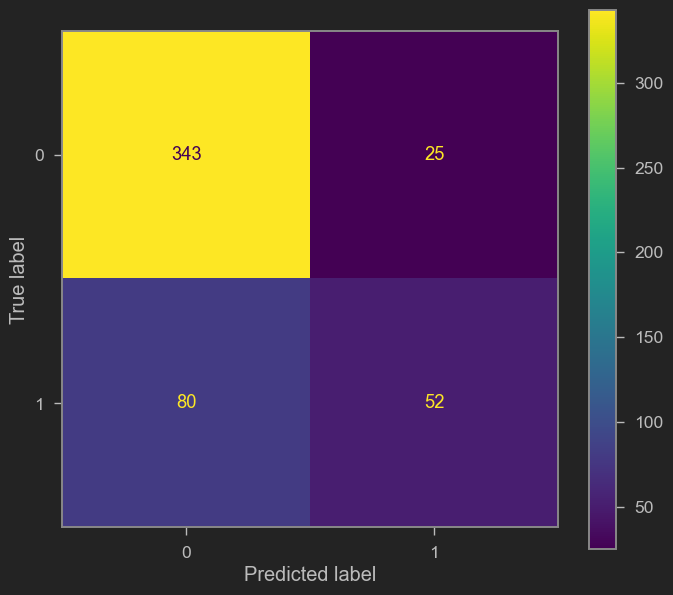

In [25]:
# Compute the confusion matrix.
cm = confusion_matrix(Y_test, predictions)

# Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Interpretation

* True Negatives (TN): 343 instances were correctly predicted as class 0. This means that for 343 cases, the model correctly identified them as being below the salary threshold.

* False Positives (FP): 25 instances were predicted as class 1 when they were actually class 0. This means that the model incorrectly predicted these cases as being above the salary threshold when they were not.

* False Negatives (FN): 80 instances were predicted as class 0 when they were actually class 1. This means the model missed identifying these cases as being above the salary threshold when they actually were.

* True Positives (TP): 52 instances were correctly predicted as class 1. This means that the model correctly identified 52 cases as being above the salary threshold.

### Intepreting the numbers
* Accuracy: This is a measure of how often the model is correct. For this model, the accuracy would be calculated as (TP + TN) / (TP + TN + FP + FN), which equates to (52 + 343) / (52 + 343 + 25 + 80) = 395 / 500 = 0.79 or 79%. This means that 79% of the time, the model's predictions are correct.

* Precision for class 1: This is a measure of how many of the items identified as class 1 were actually class 1. The precision for the model is calculated as TP / (TP + FP), which is 52 / (52 + 25) = 52 / 77 ≈ 0.6753 or 67.53%. This means that when the model predicts an instance is above the salary threshold, it is correct about 67.53% of the time.

* Recall for class 1: This measures how many of the actual class 1 items were identified as class 1. The recall for the model is TP / (TP + FN), which is 52 / (52 + 80) = 52 / 132 ≈ 0.3939 or 39.39%. This means that the model identifies about 39.39% of the actual above-salary-threshold instances correctly.

* F1 Score for class 1: This is the harmonic mean of precision and recall and is a single metric that combines both. The F1 score is 2 * (Precision * Recall) / (Precision + Recall), which would be 2 * (0.6753 * 0.3939) / (0.6753 + 0.3939) ≈ 0.4915 or 49.15%. This means that the balance between precision and recall for the model, in terms of identifying the above-salary-threshold instances, is about 49.15%.

In summary, while the model has a decent overall accuracy of 79%, it seems to struggle particularly with recall for class 1, meaning it is missing a significant number of instances that are actually above the salary threshold. Depending on the context, this might be an area to focus on for improvement, potentially by adjusting the threshold for classification or by further training the model.

# Visualize Text 
show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary.

In [26]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oyund\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oyund\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# Same function but now returning model, tfidf, predictions

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score

def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train, X_test, Y_test):
    # Vectorize dataset
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    # Define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)
 
    # Evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score(Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:", round(100*accuracy, 2), '%')
    print("Balanced accuracy:", round(100*balanced_accuracy, 2), '%')
    print("Precision:", round(100*precision, 2), '%')

    # Return the model, vectorizer, and predictions
    return model, tfidf, predictions


In [28]:
# Transform with TFIDF vectorizer and get model, tfidf and predictions
model, tfidf, predictions = transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train, X_test, Y_test)

Accuracy: 79.0 %
Balanced accuracy: 66.3 %
Precision: 67.53 %


### What were the top terms for High (Above) and Low (Below) salary?

In [29]:
# Extract feature names and log probabilities
feature_names = tfidf.get_feature_names_out()
log_prob = model.feature_log_prob_

# For positive class (Above salary threshold)
top_above_indices = np.argsort(log_prob[1])[-10:]
print("Top terms for 'Above' salary:")
for index in top_above_indices:
    print(feature_names[index])

# For negative class (Below salary threshold)
top_below_indices = np.argsort(log_prob[0])[-10:]
print("\nTop terms for 'Below' salary:")
for index in top_below_indices:
    print(feature_names[index])


Top terms for 'Above' salary:
skill
role
development
manager
management
client
team
business
experience
project

Top terms for 'Below' salary:
business
customer
team
manager
client
service
role
work
experience
sale


# Future State, Improvement, and Limitations

If I wanted to increase the accuracy of the model above, how can I accomplish this using the
dataset you have? Some points: 

1) Of course, one obvious point is to increase the sample size. 
2) Feature Engineering: Create more meaningful features from the existing data. For instance, in addition to the FullDescription, I could extract other features such as job title length, the presence of certain skills or certifications, or the seniority level implied by the job description.
3) Hyperparameter Tuning: Adjust the hyperparameters of both the TfidfVectorizer and the MultinomialNB model. For instance, I could experiment with different values of alpha for the Naive Bayes model, or I could adjust parameters like max_df, min_df, and ngram_range for the TF-IDF vectorizer to refine the feature set.
4) Advanced Text Preprocessing: Further refine the text cleaning function to handle edge cases, such as different forms of a word, misspellings, or domain-specific terms. Might also want to expand the stop words list to include terms that are common in job descriptions but not informative for salary prediction.
5) POS Tagging: Since nouns can be particularly informative in job descriptions, I could use POS tagging to focus on certain types of words, such as nouns or adjectives, which might have more predictive power regarding salaries.
6) Model Selection: Experiment with different models beyond Naive Bayes, such as logistic regression, support vector machines, or ensemble methods like random forests or gradient boosting machines, which might capture more complex patterns in the data.
7) Cross-Validation: Use k-fold cross-validation to evaluate the model's performance. This will give a more reliable estimate of its accuracy on unseen data and could help prevent overfitting.

### Let's try implementing 5. POS Tagging.

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\oyund\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oyund\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oyund\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.74
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


C:\Users\oyund\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


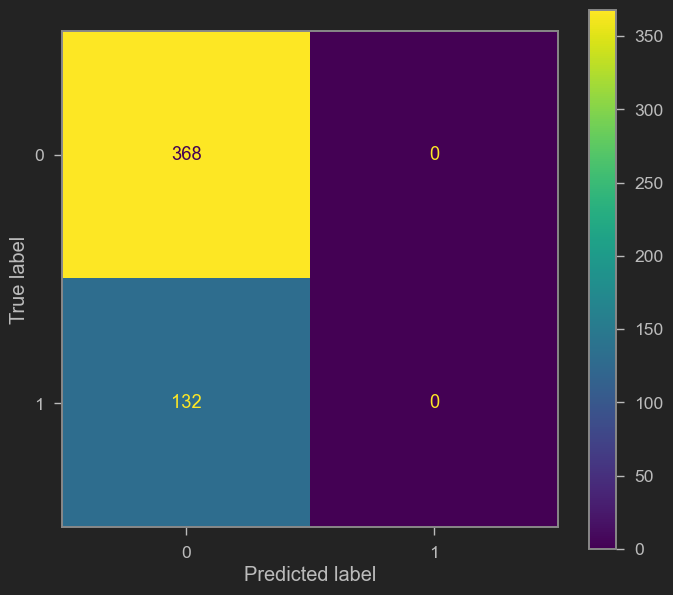

In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Download necessary NLTK datasets
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

# Define the text cleaning and POS tagging function
def text_clean(text):
    text = re.sub(r"\n", "", text)  # remove line breaks
    text = text.lower()  # convert to lowercase
    text = re.sub(r"\d+", "", text)  # remove digits
    text = re.sub(r'[^\x00-\x7f]', r' ', text)  # remove non-ascii
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)  # remove hyperlinks
    return text

def extract_nouns_adjectives(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    nouns_adjectives = [word for word, tag in tagged if tag.startswith(('NN', 'JJ'))]  # NN (Noun), JJ (Adjective)
    return ' '.join(nouns_adjectives)

# Splitting the dataset first
X_train, X_test, Y_train, Y_test = train_test_split(df['FullDescription'], df['Target'], test_size=0.2, random_state=42)

# Apply cleaning and POS tagging to the training data
X_train = X_train.apply(text_clean).apply(extract_nouns_adjectives)
X_test = X_test.apply(text_clean).apply(extract_nouns_adjectives)

# Vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Model training
model = MultinomialNB()
model.fit(X_train_tfidf, Y_train)

# Prediction and evaluation
predictions = model.predict(X_test_tfidf)
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions, average='binary')
recall = recall_score(Y_test, predictions, average='binary')
f1 = f1_score(Y_test, predictions, average='binary')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(Y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

### This is bad!

The classification model has predicted all instances as class 0, and none as class 1. This is a clear case of a model that is heavily biased towards one class. 

This could be due to several reasons:

1. Class Imbalance: If class 1 is underrepresented in the training data, the model may learn to always predict the majority class.
2. Inadequate Features: The features used to train the model might not have enough predictive power to differentiate between the two classes.
3. Model Configuration: The model's parameters may be set up in a way that it's unable to capture the complexity needed to distinguish between classes.

This needs more attention and further investigation. 

1) **Rebalancing Techniques:** To address class imbalance, could use techniques such as oversampling the minority class (class 1 in this case), undersampling the majority class, or generating synthetic samples using methods like SMOTE (Synthetic Minority Over-sampling Technique).

2) **Class Weight Adjustment:** Many machine learning algorithms allow us to set class weights to balance out the influence of each class. For instance, by increasing the weight of class 1, we can make the model 'pay more attention' to the minority class.

3) **Threshold Tuning:** Might also consider adjusting the decision threshold. By default, a threshold of 0.5 is used for binary classification, but this might not be appropriate in cases of class imbalance. Lowering the threshold for class 1 could lead to more balanced predictions.

4) **Model Evaluation on Balanced Data:** Even if we have an imbalanced dataset, we can evaluate your model on a balanced subset to see how it performs across the classes. If it performs poorly, even on a balanced subset, the issue might not be with class imbalance but with other aspects of the model or data.

# References: 

* Professor Taha's script on email classifier